In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

sub_size = 50
X_size = 1000

X_star = np.linspace(0, 3, X_size)
X = X_star.reshape(-1,1)
# Evenly sample X_size points from sub_size points
sorted_indices = np.linspace(0, X_size-1, sub_size, dtype=int)   # Generate sub_size evenly spaced indices.

X_sub = X[sorted_indices]
def RBF_kernel(X, Y, sigma2):
    X = np.array(X)
    Y = np.array(Y)
    mat1 = np.sum(X**2, 1).reshape(-1, 1)
    mat2 = np.sum(Y**2, 1)
    mat = mat1 + mat2 - 2 * np.dot(X, Y.T)
    mat = np.exp(-0.5 / sigma2 * mat)
    return mat

kTup = 10 # Hyperparameter： sigma squared
K = RBF_kernel(X_sub, X_sub, kTup) # Kernel Matrix of Fixed-Size Support Vectors

eigenvalue, featurevector = np.linalg.eig(K)    #Eigenvalue Decomposition of Kernel Matrix
A = eigenvalue             
B = featurevector

KK = RBF_kernel(X, X_sub, kTup)     # Kernel Matrix Generated from the Total Sample Set and Subsample Sets
K_1 = KK @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)

F = K_1 @ A_lam
X_F = F                                 # Primal form of the Sample Set Feature Function

X_F_1 = X_F[0,:]
X_F_1 = X_F_1.reshape(1, sub_size)

X = X_star.reshape(-1,1)
X = X[1:, :]
KK = RBF_kernel(X, X_sub, kTup)     

X_diag = np.diag(X.flatten())  # Sample Set Diagonal Matrix
X_sub_diag = np.diag(X_sub.flatten()) # Subsample Diagonal Matrix
KK_D = ( KK @ X_sub_diag - X_diag @ KK ) / (kTup)  # First-order derivative of the kernel function

eigenvalue, featurevector = np.linalg.eig(K)      
A = eigenvalue             
B = featurevector
K_1 = KK @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)

F = K_1 @ A_lam
X_F = F                               # Primal form of the Sample Set Feature Function

eigenvalue, featurevector = np.linalg.eig(K)      
A = eigenvalue             
B = featurevector
K_1 = KK_D @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)

F_D = K_1 @ A_lam
X_F_D = F_D                                 # First-Order Derivative of the Sample Set Feature Function

A = np.real(X_F_D)
B = np.real(X_F)
C = np.real(X_F_1)

n = X_size - 1      
m_vars = sub_size 

r = 1000000  #Hyperparameter: gamma

# Differential equation parameters
p = 1
t = X
I = np.ones((n, 1))          
E = np.eye(m_vars)           

d = m_vars 

# Initial Guess (Ensure the initial value of y is positive and far from zero)
w = np.zeros((d, 1), dtype=np.float64)
b = 0.0
m = 0.0
y = np.ones((n, 1), dtype=np.float64) + 1e-8

max_iter = 50     # Maximum Number of Iterations
tol = 1e-10           # Convergence Tolerance

# Construct the matrix equation and solve it.
def compute_residual(w, b, m, y):
    # 计算Y1
    Aw = A @ w
    term1 = Aw - y + t / y  
    term2 = y - B @ w - b * I
    Y1 = w + r * A.T @ term1 + r * (-B.T) @ term2 + m * C.T
    
    # 计算Y2
    Y2 = r * (-I).T @ term2 + m
    Y2 = Y2.item()  
    
    # 计算Y3
    Y3 = (C @ w).item() + b - p
    
    # 计算Y4
    factor = (1 + t / y**2)
    term4 = -r * factor * (Aw - y + t / y) + r * term2
    Y4 = term4
    
    return Y1, Y2, Y3, Y4

def compute_jacobian(w, b, m, y):

    J11 = E + r * A.T @ A + r * B.T @ B  
    J12 = r * B.T @ I                   
    J13 = C.T                           
    diag_I_t_y2 = np.diag((1 + (t / y**2)).flatten())  
    J14 = -r * A.T @ diag_I_t_y2 - r * B.T            
    
    J21 = r * I.T @ B                   
    J22 = r * I.T @ I                    
    J23 = np.array([[1.0]])              
    J24 = -r * I.T                       
    
    J31 = C                             
    J32 = np.array([[1.0]])             
    J33 = np.array([[0.0]])             
    J34 = np.zeros((1, n))              

    factor = 1 + t / y**2
    diag_factor = np.diag(factor.flatten())
    J41 = -r * diag_factor @ A - r * B  
    J42 = -r * I                        
    J43 = np.zeros((n, 1))              
    Aw = A @ w
    term_inside = (factor**2) + (2 * t / y**3) * (Aw - y + t / y) + 1
    J44 = r * np.diag(term_inside.flatten())  
    
    row1 = np.hstack([J11, J12, J13, J14])
    row2 = np.hstack([J21, J22, J23, J24])
    row3 = np.hstack([J31, J32, J33, J34])
    row4 = np.hstack([J41, J42, J43, J44])
    
    J = np.vstack([row1, row2, row3, row4])
    return J

for iter in range(max_iter):
    Y1, Y2, Y3, Y4 = compute_residual(w, b, m, y)
    
    F = np.vstack([Y1, np.array([[Y2]]), np.array([[Y3]]), Y4])
    norm_F = np.linalg.norm(F)
    print(f"Iter {iter}: Residual norm = {norm_F:.6f}")
    
    if norm_F < tol:
        print("Converged!")
        break
    
    J = compute_jacobian(w, b, m, y)
    
    try:
        delta = np.linalg.solve(J, -F)
    except np.linalg.LinAlgError:
        print("Singular Jacobian. Using least squares.")
        delta = np.linalg.lstsq(J, -F, rcond=None)[0]
    
    delta_w = delta[:d]
    delta_b = delta[d]
    delta_m = delta[d+1]
    delta_y = delta[d+2:d+2+n]
    
    w += delta_w.reshape(-1, 1)
    b += delta_b.item()
    m += delta_m.item()
    y += delta_y.reshape(-1, 1)

print("Final variables:")
print("w:", w.flatten())
print("b:", b)
print("m:", m)
print("y:", y.flatten())

#Calculate the prediction results.
X = X_star.reshape(-1,1)
KK = RBF_kernel(X, X_sub, kTup)   
eigenvalue, featurevector = np.linalg.eig(K)    
A = eigenvalue             
B = featurevector
K_1 = KK @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)
F = K_1 @ A_lam
X_F = F                                
y_p =  np.real(np.dot(X_F,w) + b)
# print(y_p)

Iter 0: Residual norm = 7446326026.705024
Iter 1: Residual norm = 54912039.285008
Iter 2: Residual norm = 63942178.695749
Iter 3: Residual norm = 4624235.212525
Iter 4: Residual norm = 16009560.137810
Iter 5: Residual norm = 719829.024756
Iter 6: Residual norm = 11973976.736272
Iter 7: Residual norm = 448992.752170
Iter 8: Residual norm = 18645655.408862
Iter 9: Residual norm = 261761.365319
Iter 10: Residual norm = 511035975.570234
Iter 11: Residual norm = 5453022.243300
Iter 12: Residual norm = 5525205575.348020
Iter 13: Residual norm = 14017199.273235
Iter 14: Residual norm = 52780050.895740
Iter 15: Residual norm = 2307274.936236
Iter 16: Residual norm = 54137.865407
Iter 17: Residual norm = 8.423287
Iter 18: Residual norm = 0.000008
Iter 19: Residual norm = 0.000052
Iter 20: Residual norm = 0.000004
Iter 21: Residual norm = 0.000119
Iter 22: Residual norm = 0.000076
Iter 23: Residual norm = 0.000039
Iter 24: Residual norm = 0.000027
Iter 25: Residual norm = 0.000139
Iter 26: Resid

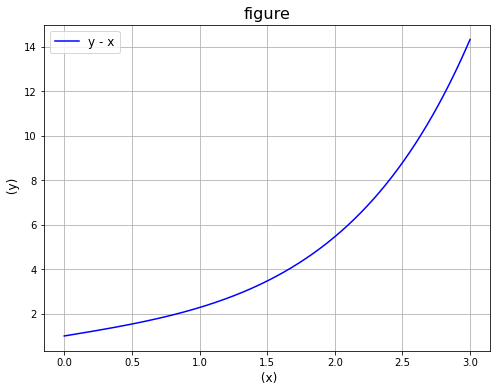

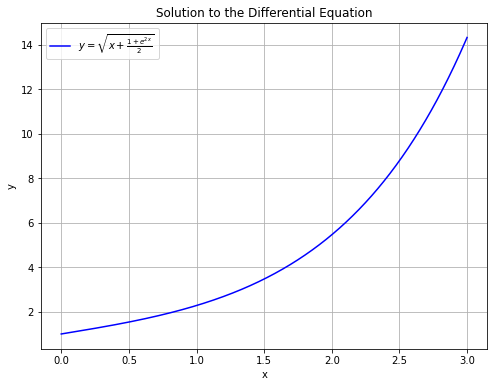

In [2]:
import matplotlib.pyplot as plt
import numpy as np

#graph of the predicted values
x = X 
a = y_p
y = y_p               
plt.figure(figsize=(8, 6))  
plt.plot(x, y, label="y - x", color="blue", linestyle="-")
plt.title("figure", fontsize=16)
plt.xlabel(" (x)", fontsize=12)
plt.ylabel(" (y)", fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


#graph of the true values
# Define the solution function
def y(x):
    return np.sqrt(x + (1 + np.exp(2 * x)) / 2)

x = np.linspace(0, 3, 1000)  # Plot from x=0 to x=2
y_vals = y(x)
b = y_vals
plt.figure(figsize=(8, 6))
plt.plot(x, y_vals, 'b-', label=r'$y = \sqrt{x + \frac{1 + e^{2x}}{2}}$')
plt.title('Solution to the Differential Equation')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd

y_p_fsvm = a
y_true = b
R2_fsvm = r2_score(y_p_fsvm, y_true)
mae_fsvm = mean_absolute_error(y_p_fsvm, y_true)
rmse_fsvm = mean_squared_error(y_p_fsvm, y_true, squared = False)
inf_norm_fsvm = np.linalg.norm(y_p_fsvm - y_true.reshape(-1, 1), ord = np.inf)
print(f"R2_fsvm: {R2_fsvm}, mae_fsvm: {mae_fsvm}, rmse_fsvm: {rmse_fsvm}, inf_norm_fsvm: {inf_norm_fsvm}") 


data_to_save = pd.DataFrame({
    'y_pred_fsvm': y_p_fsvm.flatten()
})

data_to_save.to_csv('fsvm_04.csv', index=False)
print(" fsvm_04.csv")

R2_fsvm: 0.9999999625556644, mae_fsvm: 0.0005468562586873527, rmse_fsvm: 0.0006915937916926086, inf_norm_fsvm: 0.0015027609404008047
数据已保存至 fsvm_04.csv
